In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import torchvision.datasets as dset
import torchvision.transforms as T

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os

from models import DCGAN

In [2]:
class bedrood(Dataset):
    def __init__(self, root_path, mode='train', resize=64):
        self.root_path = root_path
        self.mode = mode
        self.file_path = os.listdir(root_path+'/'+mode)
        self.transform = T.Compose([
            T.ToTensor(),
            T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        self.resize = resize
        
    def resize2d(self, img):
        with torch.no_grad():
            img = (F.adaptive_avg_pool2d(Variable(img), (self.resize,self.resize))).data
        return img
        
    def __getitem__(self, index):
        img = mpimg.imread(self.root_path + '/'+self.mode+'/' + self.file_path[index])
        img = self.transform(img)
        img = self.resize2d(img)
        
        return img, 0
    
    def __len__(self):
        return len(self.file_path)

In [3]:
trainset = bedrood('data/bedroom',mode='train')
train_loader = DataLoader(trainset, batch_size=128)
# validset = bedrood('/root',mode='val',transform=transform)
# valid_loader = DataLoader(validset, batch_size=100)
# testset = bedrood('/root',mode='test',transform=transform)
# test_loader = DataLoader(testset, batch_size=100)
print(len(train_loader))
# print(len(valid_loader))
# print(len(test_loader))

235


In [4]:
torch.cuda.is_available()

True

In [5]:
def reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()

In [6]:
### parameter ###
dtype = torch.cuda.FloatTensor
latent_dim = 100
input_size = 64
hidden_dim = 100

G = DCGAN.Generator(latent_dim, input_size, hidden_dim, dtype)
D = DCGAN.Discriminator(input_size, hidden_dim, dtype)

loss_fn = nn.BCELoss().type(dtype)

G_optimizer = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

torch.cuda.random.manual_seed(12345)
G.apply(reset)
D.apply(reset)

Discriminator(
  (features): Sequential(
    (0): Conv2d(3, 100, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(100, 200, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace)
    (5): Conv2d(200, 400, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace)
    (8): Conv2d(400, 800, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(800, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace)
    (11): Conv2d(800, 1, kernel_size=(4, 4), stride=(1, 1))
    (12): Sigmoid()
  )
)

In [7]:
trainer = DCGAN.Trainer(D, D_optimizer, G, G_optimizer, dtype)

Starting 1/10
Time: 191.2293, D loss 0.7257, G loss 3.6954


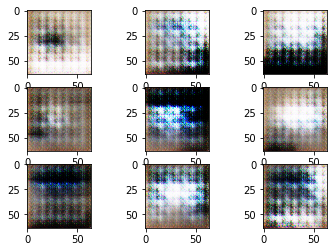

Starting 2/10
Time: 177.4904, D loss 0.6883, G loss 3.2319


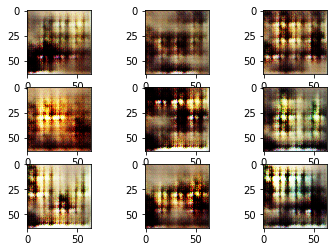

Starting 3/10
Time: 160.2780, D loss 0.5895, G loss 4.0663


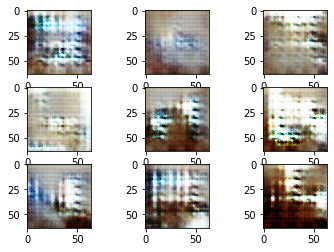

Starting 4/10
Time: 160.0898, D loss 0.5046, G loss 4.2933


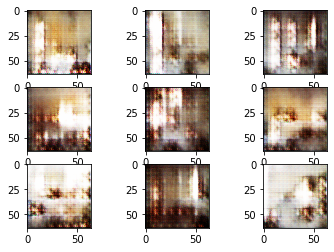

Starting 5/10
Time: 158.3929, D loss 0.4715, G loss 4.3675


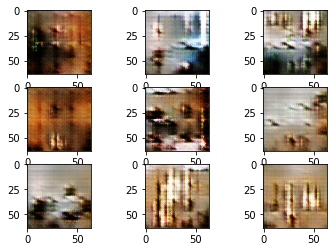

Starting 6/10
Time: 155.9049, D loss 0.4169, G loss 4.3728


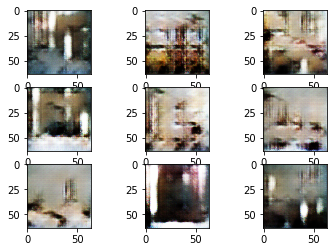

Starting 7/10
Time: 156.6426, D loss 0.3577, G loss 4.7305


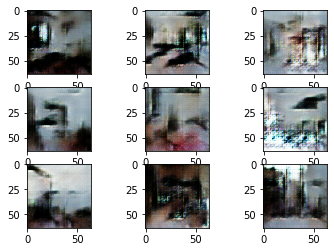

Starting 8/10
Time: 157.8026, D loss 0.3445, G loss 4.9784


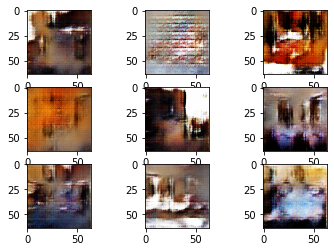

Starting 9/10
Time: 157.9837, D loss 0.3081, G loss 5.0277


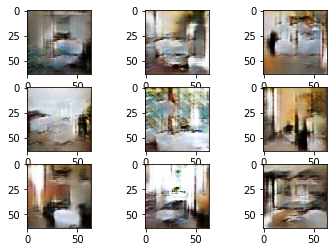

Starting 10/10
Time: 157.3849, D loss 0.3155, G loss 5.1025


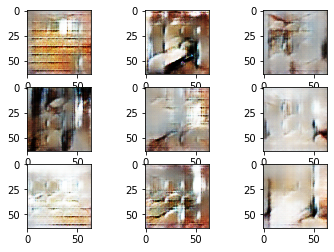

In [8]:
trainer.train(10, train_loader, loss_fn, 1, 9)

In [11]:
torch.save(trainer.D.state_dict(), 'checkpoint/bedroom/190524/discriminator_param.pkl')
torch.save(trainer.G.state_dict(), 'checkpoint/bedroom/190524/generator_param.pkl')